In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Ahora las funciones utiles de sklearn para preprocesar datos y armar un pipeline
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as pp

#Y la estrella de este notebook:
from sklearn import svm

# SVM: Clasificación

## Utilidades de ploteo:

Será util definir una función para plotear lindos los datos. Así como otra para plotear las predicciones de un modelo de scikit-learn (es decir la frontera de descición y pintar las regiones con colorcitos)

In [2]:
#Este es el rango de X e Y que se ve bien para nuestro dataset
DEFAULT_AXIS=[-1.5, 2.5, -1, 1.5]

def plot_dataset(X, y, axes=DEFAULT_AXIS):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def plot_predictions(clf, axes=DEFAULT_AXIS, plot_sv=False, plot_cont=True):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    if plot_cont:
        plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    if plot_sv:
        try:
            svs = clf[:-1].inverse_transform(clf.steps[-1][1].support_vectors_)
            plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
        except:
            print("LinearSVC no guarda los Support Vectors, para eso us SVC con kernel='linear'")

## Importamos / Generamos los Datos

Vamos a generar datos que no son linealmente separables usando la función make_moons de scikit-learn

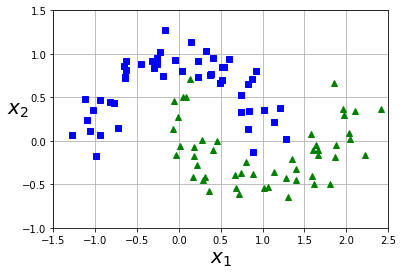

In [3]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
plot_dataset(X, y)
plt.show()

## SVM lineal para clasificación: svm.LinearSVC

Primero usaremos una SVM para clasificación con un kernel lineal. Esta está implementada en ``svm.LinearSVC`` (la _C_ al final es por *Classifier*).

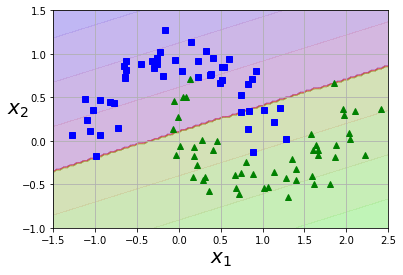

In [4]:
linear_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.LinearSVC(C=10, loss="hinge", random_state=42))
    ])

linear_svm_clf.fit(X, y)

plot_predictions(linear_svm_clf)
plot_dataset(X,y)
plt.show()

Como vemos, es pésimo, dado que los datos no son linealmente separables... Quizas un ajuste polinómico capture mejor el comportamiento del plot.

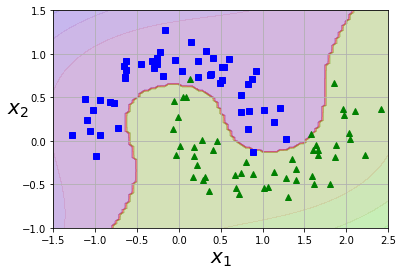

In [5]:
polynomial_svm_clf = Pipeline([
        ("poly_features", pp.PolynomialFeatures(degree=3)),
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

plot_predictions(polynomial_svm_clf)
plot_dataset(X,y)
plt.show()

## SVM no lineal para clasificación: svm.SVC

Una de las ventajas de las SVM es que solo dependen de los features $\phi$ a travez de su producto interno $K({\bf a},{\bf b}) = \phi({\bf a})^T \phi({\bf b})$. Esto define al _kernel_, y nos permite utilizar features mucho mas complejos, de dimensiones mucho mas grandes, sin tener que calcularlos explicitamente, mientras podamos calcular el kernel. Esta es la versión más general de las SVM para clasificación y el secreto de su poder. Estan implementados en la clase ``svm.SVC``, veamos algunos casos particulares.

Uno puede definir sus propios Kernels (incluso como simples funciones de python), pero los que vienen definidos por defecto en Scikit-Learn son los siguientes:

* ``linear``: $K({\bf a},{\bf b}) = {\bf a}^T {\bf b}$. 
Este es una SVM lineal, y se recomienda usar LinearSVC ya que es mucho más rápido y eficiente.
* ``poly``: $K({\bf a},{\bf b}) = \left(\gamma {\bf a}^T {\bf b} + r\right)^d$. 
Este es un kernel polinomial, y a diferencia de usar un kernel lineal con PolynomialFeatures, no requiere calcular la matriz de diseño lo cual es optimo para grados altos.
* ``rbf``: $K({\bf a},{\bf b}) = \exp\left(-\gamma||{\bf a}- {\bf b}||^2\right)$
Este es un kernel gaussiano, y correspondería a tomar un features $\phi$ de dimensión infinita (continua). Por suerte, su kernel se escribe de forma sencilla y es muy flexible.
* ``sigmoid``: $K({\bf a},{\bf b}) = \tanh\left(\gamma{\bf a}^T {\bf b} + r\right)$

Los cuales se pueden elegir con el argumento ``kernel=``, mientras que para sus parametros:
* $d $ se especifica en el argumento ``degree``
* $\gamma\ge 0$ se especifica en el argumento ``gamma``
* $r$ se especifica en el argumento ``coef0``

### Kernel: Lineal

$K({\bf a},{\bf b}) = {\bf a}^T {\bf b}$

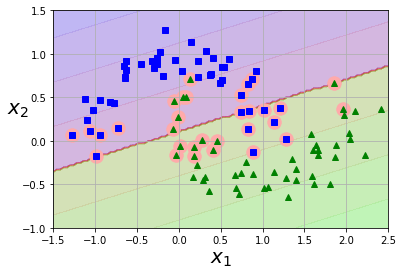

In [6]:
linear_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(kernel='linear', C=10, random_state=42))
    ])

linear_svm_clf.fit(X, y)

plot_predictions(linear_svm_clf,plot_sv=True)
plot_dataset(X,y)
plt.show()

### Kernel: Polinomial

$K({\bf a},{\bf b}) = \left(\gamma {\bf a}^T {\bf b} + r\right)^d$
* $d $ se especifica en el argumento ``degree``
* $\gamma\ge 0$ se especifica en el argumento ``gamma``
* $r$ se especifica en el argumento ``coef0``

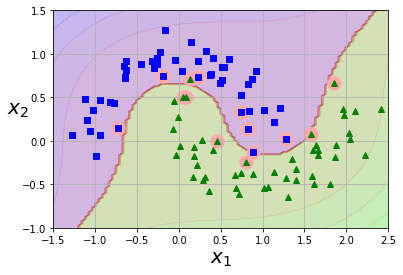

In [7]:
polynomial_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(kernel='poly', degree=3, coef0=1, C=10, random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

plot_predictions(polynomial_svm_clf, plot_sv=True)
plot_dataset(X,y)
plt.show()

### Kernel: Gaussiano

$K({\bf a},{\bf b}) = \exp\left(-\gamma||{\bf a}- {\bf b}||^2\right)$
* $\gamma\ge 0$ se especifica en el argumento ``gamma``

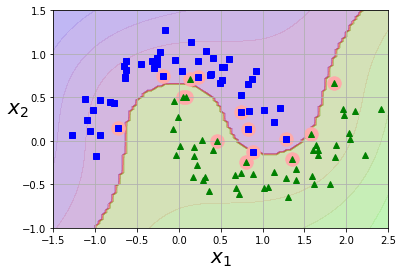

In [8]:
gaussian_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(kernel='rbf', gamma=0.1, C=10**3, random_state=42))
    ])

gaussian_svm_clf.fit(X, y)

plot_predictions(gaussian_svm_clf, plot_sv=True)
plot_dataset(X,y)
plt.show()

### Kernel: Sigmoide

$K({\bf a},{\bf b}) = \exp\left(-\gamma||{\bf a}- {\bf b}||^2\right)$
* $\gamma\ge 0$ se especifica en el argumento ``gamma``
* $r$ se especifica en el argumento ``coef0``

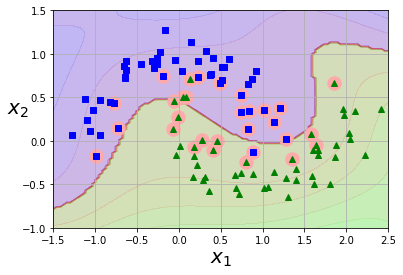

In [9]:
sigmoid_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(kernel='sigmoid', gamma=0.7, coef0=-2, C=10, random_state=42))
    ])

sigmoid_svm_clf.fit(X, y)

plot_predictions(sigmoid_svm_clf, plot_sv=True)
plot_dataset(X,y)
plt.show()

# SVM: Regresión

El equivalente a las clases ``LinearSVC`` y ``SVC`` para regresión son las clases ``LinearSVR`` y ``SVR``, con idénticos parámetros y kernels. A continuación mostraremos como se desempeñan en el dataset de Housing de california, que ya hemos usado antes.

Recordemos que el Clasificador intenta maximizar el margen entre clases, admitiendo o no excepciones segun el valor de ``C``. En el caso de Regresión, intenta meter todas los puntos dentro de un margen que nosotros especificamos con ``epsilon``, y admite excepciones segun el valor de ``C``.. Este  ``epsilon`` es un parámetro nuevo que el clasificador no tiene.

## Utilidades de Ploteo

In [10]:
DEFAULT_AXES=[-1, 1, 0, 1]

def plot_svm_regression(svm_reg, X, y, axes=DEFAULT_AXES):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

## Importamos / Generamos los datos

Como caso sencillo, hagamos una cuadratica con un poco de ruido (una normal de ancho $\sigma=0.1$). Samplearemos 100 puntos.

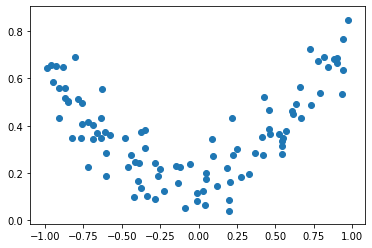

In [11]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

plt.scatter(X,y)
plt.show()

## Fiteamos con SVR

Abajo utilizaremos un kernel polinomial de grado 2. Como sabemos que el ancho del ruido es $\sigma=0.1$, fijemosnos que pasa colocando un ``epsilon=0.1``. El valor de C=100 indica cuantas excepciones permitimos.

Veamos que pasa al variar ``epsilon``.

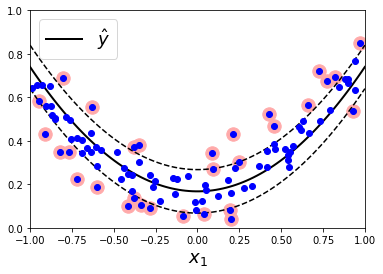

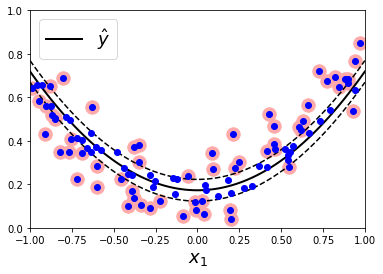

In [12]:
#C=100, epsilon=0.1
svm_poly_reg = svm.SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)
plot_svm_regression(svm_poly_reg, X, y)
plt.show()

#C=100, epsilon=0.05
svm_poly_reg = svm.SVR(kernel="poly", degree=2, C=100, epsilon=0.05, gamma="scale")
svm_poly_reg.fit(X, y)
plot_svm_regression(svm_poly_reg, X, y)
plt.show()

## Caso ejemplo: California Housing

In [13]:
#Obtengo los datos desde sklearn: Esta funcion los descarga por nosotros
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

print(housing['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [14]:
#Este DataSet solo contiene atributos numéricos
housing['feature_names']

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

Ahora, dividamos los datos y utilicemos un StandardScaler para escalearlos.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = pp.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Veamos como se desempeña un SVR lineal. Midamos el desempeño en el Training Set para detectar un posible under-fit.

In [16]:
lin_svr = svm.LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

from sklearn.metrics import mean_squared_error
y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

/Users/ignacio/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.976993881287582

El target está medido en decenas de miles de dólares, así que le estamos pifiando al training set por $\sim 10000$USD, que es bastante feo. Claramente un modelo lineal no es suficiente para ajustar los datos.

Probemos un kernel gaussiano (RBF), que es el default de ``SVR``. Para encontrr los mejores parámetros de ``gamma``y ``C`` usamos validación cruzada con ``RandomizedSearchCV``, que es algo así como la ``GridSearchCV`` solo que en vez de evaluar en una grilla, toma puntos al azar de una distribución (que se la damos con scikit-learn).

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm.SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   5.8s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   5.7s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   5.7s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   5.3s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   5.5s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   5.4s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   4.7s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   4.6s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2636de90>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2636da90>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

El mejor modelo que encontró es:

In [18]:
mejor_estimador = rnd_search_cv.best_estimator_
mejor_estimador

SVR(C=4.745401188473625, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.07969454818643928, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

Miremos que tal ajusta el training set.

In [19]:
y_pred = mejor_estimador.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.5727524770785359

Ahora tenemos un error de uns 5.7 mil USD, bastante mejor que el lineal. Veamos que tal se desempeña en el Test set.

In [20]:
y_pred = mejor_estimador.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.5929168385528734

El error es solo ligeramente mayor al training set, lo que indica que nuestro modelo generaliza bien (no hay over-fitting), y podemos esperar predicciones con un error de $\sim 5900$ USD sobre el precio de las casas.

**Ejercicio:** Compare esto con las técnicas de regresión que vio anteriormente (por ejemplo, un ajuste polinomial).